In [1]:
local = True

In [2]:
if not local:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [3]:
if not local:
    %cd /content/drive/MyDrive/Sun/ML Shock/Final project/

In [4]:
import sys
if local:
    sys.path.insert(0,"C:/Users/Amy/Desktop/Green_Git/eegClassification/utils")
else:
    sys.path.insert(0,"/content/drive/MyDrive/Sun/ML Shock/Final project/")

In [5]:
# specify the image classes
classes = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]
N_classes = len(classes)

In [24]:
# Import libraries
import numpy as np
import os
import pickle
import torch

In [7]:
# Type of input data
data_type = "spec" # "eeg_raw" #"eeg_spec"  #
# number of subprocesses to use for data loading
import multiprocessing as cpu
num_workers = 0 #cpu.cpu_count() #- 1
# how many samples per batch to load
batch_size = 64


In [8]:
# Load (train or test) data from csv file
if local:
    path = f"C:/Users/Amy/Desktop/Green_Git/eegClassification/"
else:
    path = f"./"


In [15]:
text = 'predictions'
data_path = path+f'models/'
data_files = os.listdir(data_path)
data_features = [f for f in data_files if f.startswith(text)]
data_votes = [f for f in data_files if f.startswith('labels')]
N_items = len(data_features)

print("Number of items", N_items)

Number of items 12


In [16]:
np.load(data_path+data_features[1]).shape, np.load(data_path+data_votes[1]).shape

((22051, 6), (22051, 6))

In [271]:
# load all data_features into a single numpy array
X = []
Y = []
rows = []
for i in range(N_items):

    X_tmp = np.load(data_path+data_features[i])
    Y_tmp = np.load(data_path+data_votes[i])
    # if axis = -1 contains a nan then drop that row
    for r in np.where(np.isnan(X_tmp))[0]:
        rows.append(r)
rows = np.unique(rows)
print(rows)

for i in range(N_items):
    # exclude rows with nan
    X_tmp = np.load(data_path+data_features[i])
    Y_tmp = np.load(data_path+data_votes[i])
    X_tmp = np.delete(X_tmp, rows, axis = 0)
    X_tmp = X_tmp.reshape(1, *X_tmp.shape)
    Y_tmp = np.delete(Y_tmp, rows, axis = 0)
    Y_tmp = Y_tmp.reshape(1, *Y_tmp.shape)
    

    X.append(X_tmp)
    Y.append(Y_tmp)

X = np.vstack(X)
X= np.exp(X)
Y = np.vstack(Y)
Y = Y[0,:,:].reshape(1, *Y.shape[1:])

N_samples = X.shape[1]

[ 7885  8050 12583 17588 17904 18221]


In [266]:
# indices where X is nan
np.where(np.isnan(X))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [267]:
X.shape, Y.shape

((12, 22045, 6), (1, 22045, 6))

In [268]:
theta = [1/12]*12
theta = np.array(theta).reshape(12,1,1)

In [269]:
X.shape, Y.shape, theta.shape

((12, 22045, 6), (1, 22045, 6), (12, 1, 1))

In [272]:
# multiply the data by the weights
X_1 = np.sum(theta*X, axis=0)
X_1 = X_1/X_1.sum(axis=-1).reshape(N_samples, 1)

In [273]:
X_1.shape

(22045, 6)

In [274]:
X_1[0,0], np.sum(X[:,0,0])/12

(0.08786728749733841, 0.0878672997156779)

In [275]:
Y[0,0,:]

array([0, 1, 0, 0, 0, 4], dtype=int64)

In [277]:
# convert votes to class probabilities
Y_p = Y/np.sum(Y, axis=2).reshape(1,N_samples,1)

In [278]:
Y_p.shape, Y_p[0,0,:]

((1, 22045, 6), array([0. , 0.2, 0. , 0. , 0. , 0.8]))

In [279]:
np.sum(Y_p[0,0,:]), np.sum(X_1[0,:])

(1.0, 1.0)

In [309]:
# kl divergence taking into account zeros
def kl(p, q):
    p = np.maximum(p, 1e-12)
    q = np.maximum(q, 1e-12)
    return np.mean(p * np.log(p / q))

def mean_KL(Y_p, X_1, N_samples, N_classes):
    # apply kl divergence to all time points
    KL = np.zeros((N_samples, N_classes))
    for i in range(N_samples):
        KL[i] = kl(Y_p[0,i,:], X_1[i,:])

    KL = np.sum(KL, axis=1)

    return np.mean(KL)


In [310]:
mean_KL(Y_p, X_1, N_samples, N_classes)

1.226523231047077

In [284]:
Y_p = Y/np.sum(Y, axis=2).reshape(1,N_samples,1)

In [286]:
Y_p.shape, X.shape, np.sum(theta*X, axis=0).reshape(1,N_samples,6).shape

((1, 22045, 6), (12, 22045, 6), (1, 22045, 6))

In [287]:
Y_p[0,0,:], X[0,0,:], np.sum(theta*X, axis=0).reshape(1,N_samples,6)[0,0,:]

(array([0. , 0.2, 0. , 0. , 0. , 0.8]),
 array([0.2382106 , 0.05618012, 0.07114807, 0.17983127, 0.33484328,
        0.11978664], dtype=float32),
 array([0.08786729, 0.33398305, 0.08823288, 0.07981225, 0.07729109,
        0.33281343]))

In [375]:
#multiply the X by Y_p
theta_0

array([[[0.08333333]],

       [[0.08333333]],

       [[0.08333333]],

       [[0.08333333]],

       [[0.08333333]],

       [[0.08333333]],

       [[0.08333333]],

       [[0.08333333]],

       [[0.08333333]],

       [[0.08333333]],

       [[0.08333333]],

       [[0.08333333]]])

In [389]:
.shape

(12, 22045, 6)

In [410]:
np.sum(np.sum((Y_p*X)/np.sum(y_hat, axis=0).reshape(1,N_samples,6), axis = -1), axis = -1)-1

array([-191.55656544, -183.94014997, -161.73437192, -169.45302047,
       -110.64022292, -107.65690418, -112.09722411, -110.88662572,
        -89.39373207,  -86.50996576,  -85.40295654,  -86.66390343])

1.32
0.92


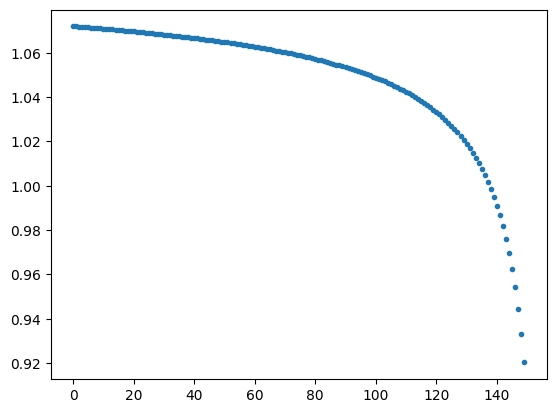

In [424]:
theta = [1/12]*12
theta_0 = np.array(theta).reshape(12,1,1)
X_0 = np.sum(y_hat, axis=0) 
X_0 = X_0/X_0.sum(axis=-1).reshape(N_samples, 1)

print(f"{mean_KL(Y_p, X_0, N_samples, N_classes):.2f}")

KL = []
lr = 0.001
for _ in range(150):

    grad = (np.sum(np.sum((Y_p*X)/np.sum(theta_0*X, axis=0).reshape(1,N_samples,6), axis = -1), axis = -1) -1)#
    theta_new = (theta_0.reshape(12) - lr*grad).reshape(12,1,1)
    
    X_0 = np.sum(theta_new*X, axis=0) 
    X_0 = X_0/X_0.sum(axis=-1).reshape(N_samples, 1)
    KL.append(mean_KL(Y_p, X_0, N_samples, N_classes))
    if len(KL)>1:
        if KL[-1]>KL[-2]:
            break
        else:
            theta_0 = theta_new

    # break

print(f"{mean_KL(Y_p, X_0, N_samples, N_classes):.2f}")
# plot the KL divergence
import matplotlib.pyplot as plt
plt.plot(KL, '.')

0.92


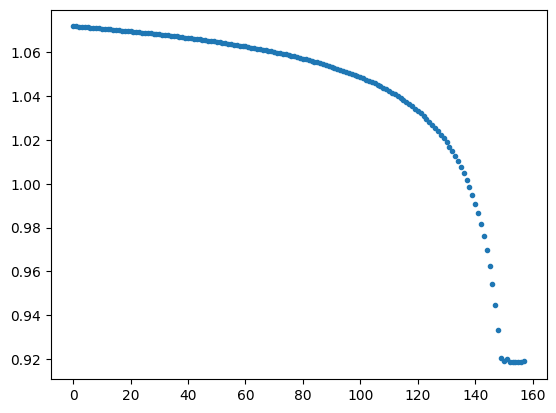

In [426]:
lr = 0.00001
for _ in range(150):

    grad = (np.sum(np.sum((Y_p*X)/np.sum(theta_0*X, axis=0).reshape(1,N_samples,6), axis = -1), axis = -1) -1)#
    theta_new = (theta_0.reshape(12) - lr*grad).reshape(12,1,1)
    
    X_0 = np.sum(theta_new*X, axis=0) 
    X_0 = X_0/X_0.sum(axis=-1).reshape(N_samples, 1)
    KL.append(mean_KL(Y_p, X_0, N_samples, N_classes))
    if len(KL)>1:
        if KL[-1]>KL[-2]:
            break
        else:
            theta_0 = theta_new

    # break

print(f"{mean_KL(Y_p, X_0, N_samples, N_classes):.2f}")
plt.plot(KL, '.')

In [427]:
data_features

['predictions_CustomCNN_0.npy',
 'predictions_CustomCNN_1.npy',
 'predictions_CustomCNN_2.npy',
 'predictions_CustomCNN_3.npy',
 'predictions_CustomCNN_eeg_0.npy',
 'predictions_CustomCNN_eeg_1.npy',
 'predictions_CustomCNN_eeg_2.npy',
 'predictions_CustomCNN_eeg_3.npy',
 'predictions_CustomCNN_eeg_4.npy',
 'predictions_CustomCNN_eeg_5.npy',
 'predictions_CustomCNN_eeg_6.npy',
 'predictions_CustomCNN_eeg_7.npy']

In [429]:
theta_0.reshape(12)/np.sum(theta_0.reshape(12))

array([ 0.24426497,  0.23135722,  0.21024972,  0.22440694,  0.02922657,
        0.02547867,  0.03331454,  0.03324735, -0.00600122, -0.00562382,
       -0.0091967 , -0.01072423])

In [430]:
y_test_class = np.argmax(Y_p, axis=2)[0,:]
predictions = np.argmax(X_0, axis=1)

In [431]:
# evaluate predictions
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_class, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 52.37%


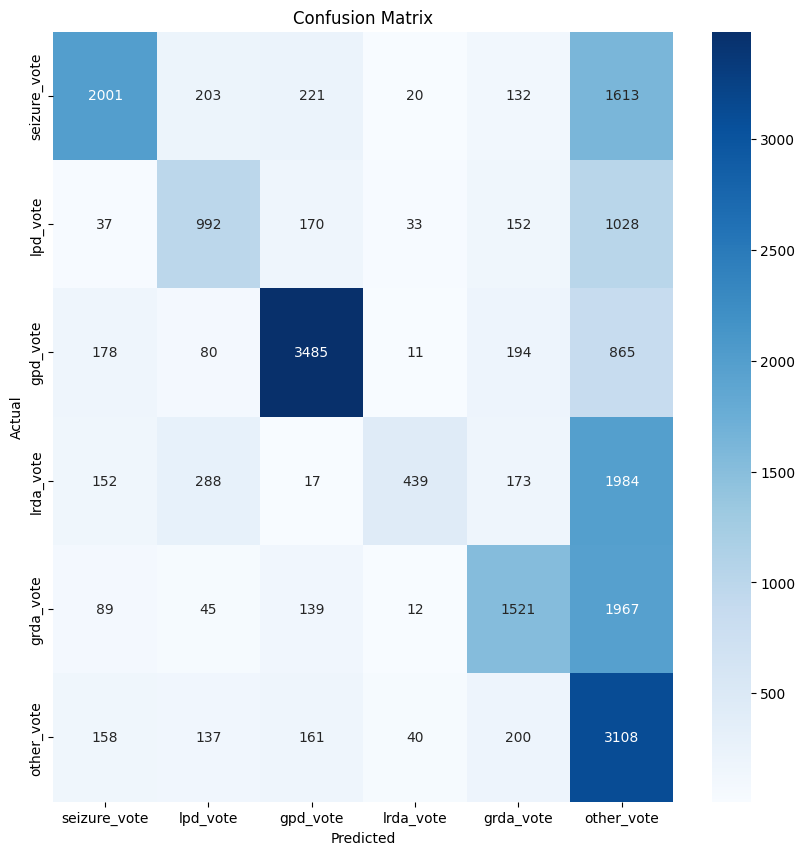

In [432]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(y_test_class, predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='Blues')
plt.xticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Text(0.5, 1.0, 'Confusion Matrix')

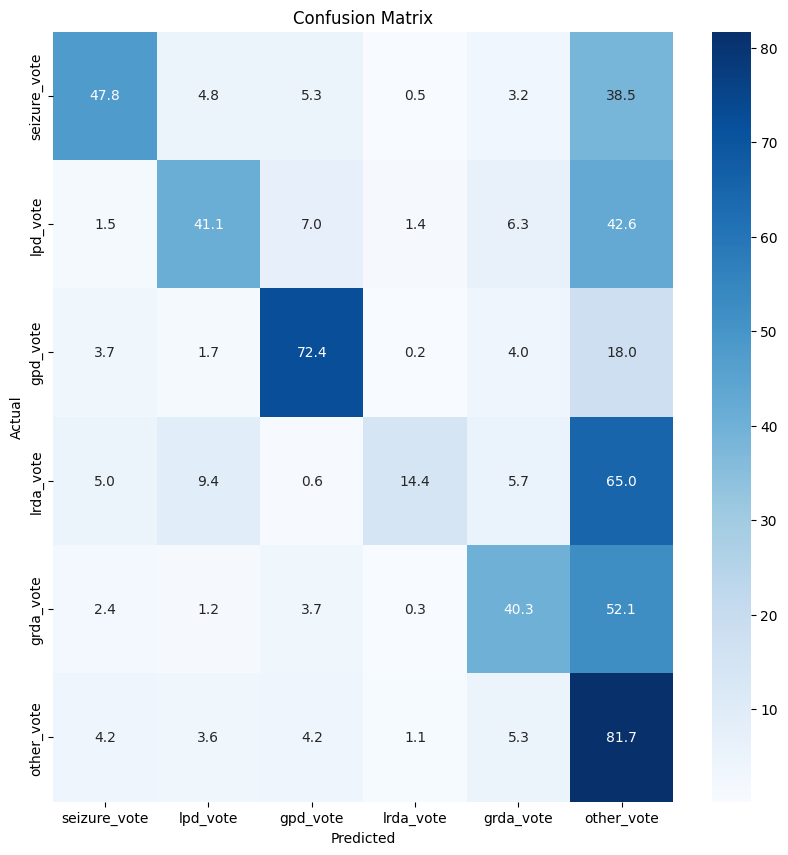

In [433]:
cm_p  = confusion_matrix / confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm_p * 100, annot=True, fmt=".1f", cmap="Blues")
plt.xticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

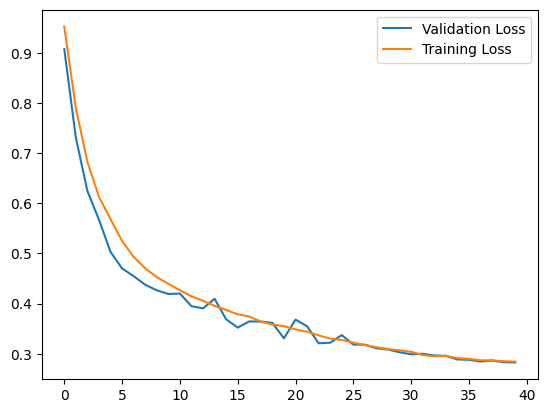

In [435]:
val_loss = [
        0.9072676899298182,
        0.730944975142209,
        0.6245396636567025,
        0.5674471399694119,
        0.5031193649993753,
        0.47013840427938497,
        0.45485261611218725,
        0.4375976325206037,
        0.4266643157545126,
        0.41923402761513334,
        0.4200594097938178,
        0.39488946536801894,
        0.3904890627231238,
        0.40970647976083574,
        0.368691556464951,
        0.35223191487339306,
        0.36453900376580795,
        0.36421901330632983,
        0.36159966565528007,
        0.3308185113488503,
        0.36816260016189434,
        0.35490222050333925,
        0.3209798753261566,
        0.3220680678228162,
        0.33727076570942716,
        0.318374739165576,
        0.31812799342398373,
        0.31101222375653825,
        0.30854092088510404,
        0.30304547092824613,
        0.29898784638575787,
        0.2999872381394764,
        0.2967207021870703,
        0.2959202766980765,
        0.28870194790498266,
        0.2881752737288205,
        0.2846780595352065,
        0.2866503304468011,
        0.283260142015961,
        0.28270129713247405
]

train_loss = [
    0.9523426424588589,
    0.7895790618494534,
    0.682634751077181,
    0.6129025307994128,
    0.5684795230486084,
    0.5248669277922433,
    0.493115201183615,
    0.4702461358783599,
    0.45273456084581626,
    0.4394227588018834,
    0.42655365111248156,
    0.4145737323934669,
    0.4055516094166711,
    0.3955542723328411,
    0.3874277545521591,
    0.3786936213131095,
    0.37436048741484995,
    0.36437485885146437,
    0.3584846697726561,
    0.35515306732117735,
    0.34856333196614303,
    0.34393516677725167,
    0.33672274365781496,
    0.3302710924012095,
    0.3275490975396861,
    0.3222686970076024,
    0.3173941055219356,
    0.31323636780680636,
    0.30931050276124716,
    0.3070015613070725,
    0.30400845504303303,
    0.297512164531503,
    0.29510167248145297,
    0.2958390600944084,
    0.2912776939070439,
    0.2898940584686644,
    0.28708561617694267,
    0.2868631649603794,
    0.28518821245505205,
    0.2843480617118085
]

plt.plot(val_loss, label="Validation Loss")
plt.plot(train_loss, label="Training Loss")
plt.legend()

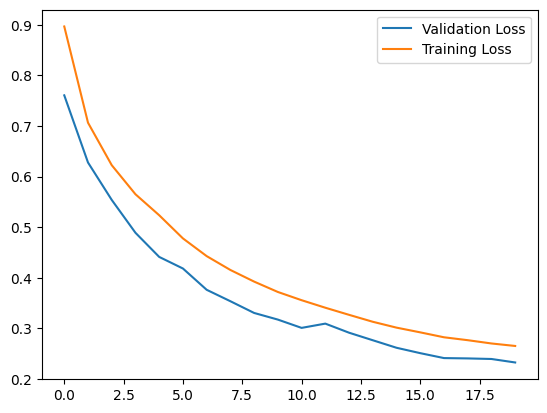

In [436]:
val_loss =[
        0.7606623096286126,
        0.6279323262988397,
        0.5540183442943502,
        0.48904308418058,
        0.4413724452819464,
        0.4184565179752854,
        0.37641176097797896,
        0.3538047340680968,
        0.3306368266636471,
        0.3175119599643743,
        0.30112897146422907,
        0.30955614891816985,
        0.29159744938589494,
        0.27669731282962945,
        0.261846510081921,
        0.25118472109425743,
        0.24145668851879407,
        0.24079635390695536,
        0.2396674559926087,
        0.23277083342930055
    ]

train_loss = [
        0.8967343592981123,
        0.7065808256842055,
        0.6226603247365862,
        0.5651910423107867,
        0.5237143938271505,
        0.47794887313865264,
        0.44296785041971026,
        0.4155598505066251,
        0.3925898695751181,
        0.3720885287056554,
        0.3558382437335995,
        0.3409730220600119,
        0.32692146922619836,
        0.3132023771978774,
        0.3016210855880998,
        0.29228144345699614,
        0.28255577582233354,
        0.27682224834021535,
        0.27033000595445905,
        0.26540306525410345
    ]

plt.plot(val_loss, label="Validation Loss")
plt.plot(train_loss, label="Training Loss")
plt.legend()